# Corrective RAG

- 논문: https://arxiv.org/pdf/2401.15884

**배경**
- RAG의 답변 결과는 검색된 문서의 관련성에 크게 의존적
- 따라서, 검색이 잘못된 경우 답변에 대한 품질 우려가 됨

**제안**
- 사용자 입력 쿼리(query) 에 대하여 검색된 문서의 품질을 평가
- 한마디로 검색된 결과가 사용자 입력 쿼리와 관련성이 높도록 쿼리를 수정(Corrective)

![](https://teddylee777.github.io/images/2024-03-06-langgraph-agentic-rag/nodes-and-edges.png)


In [3]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [5]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## GraphState

각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [6]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

## 노드와 엣지

주요 개념

- **GraphState(상태 저장 그래프)**: LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- **Node(노드)**: 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- **Edge(엣지)**: 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.


In [14]:
from langchain_upstage import UpstageGroundednessCheck
from langchain_core.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()


# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    retrieved_docs = pdf_retriever.invoke(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context="".join([doc.page_content for doc in retrieved_docs]))


#
def llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer=pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        ),
        context=state["context"],
        question=state["question"],
    )


def rewrite(state):
    question = state["question"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to improve the question. Question must be written in same language. Don't narrate, just reponse an improved question.",
            ),
            (
                "human",
                "Look at the input and try to reason about the underlying semantic intent / meaning."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nFormulate an improved question:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke({"question": question})
    return GraphState(
        context=state["context"], question=response, answer=state["answer"]
    )


def relevance_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )


def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [15]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크
workflow.add_edge("rewrite", "retrieve")  # 재작성 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

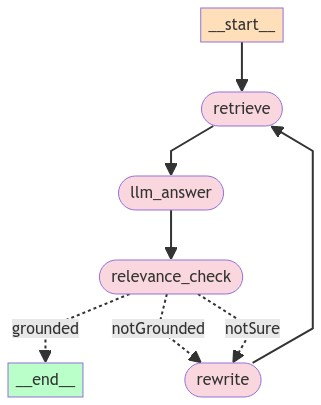

In [16]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [17]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=11, configurable={"thread_id": "CORRECTIVE-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="생성형 AI 가우스를 만든 회사의 2023년도 매출액은 얼마인가요?"
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'retrieve':"
'---'
{ 'context': '앤스로픽에 최대 40억 달러의 투자 계획을 공개\n'
             '∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해\n'
             '4년간 30억 달러 규모의 계약을 체결\n'
             '∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela '
             'Amodei)\n'
             '남매가 2021년 설립한 앤스로픽은 챗GPT의 대항마 ‘클로드(Claude)’ LLM을 개발\n'
             'n 아마존과 구글의 앤스로픽 투자에 앞서, 마이크로소프트는 차세대 AI 모델의 대표 주자인 오픈\n'
             'AI와 협력을 확대\n'
             '∙ 마이크로소프트는 오픈AI에 앞서 투자한 30억 달러에 더해 2023년 1월 추가로 100억 달러를\n'
             '투자하기로 하면서 오픈AI의 지분 49%를 확보했으며, 오픈AI는 마이크로소프트의 애저(Azure)\n'
             '클라우드 플랫폼을 사용해 AI 모델을 훈련\n'
             '£구글, 클라우드 경쟁력 강화를 위해 생성 AI 투자 확대SPRi AI Brief |\n'
             '2023-12월호\n'
             '미국 법원, 예술가들이 생성 AI 기업에 제기한 저작권 소송 기각\n'
             'KEY Contents\n'
             'n 미국 캘리포니아 북부지방법원은 미드저니, 스태빌리티AI, 디비언트아트를 대상으로 예술가\n'
             '3인이 제기한 저작권 침해 소송을 기각\n'
             'n 법원은 기각 이유로 고소장에 제시된 상당수 작품이 저작권청에 등록되지 않았으며, AI로\n'

In [12]:
print("Question: \t", output["relevance_check"]["question"])
print("Answer: \t", output["relevance_check"]["answer"])
print("Relevance: \t", output["relevance_check"]["relevance"])

Question: 	 2023년에 생성형 AI '가우스'를 개발한 회사의 연간 매출액은 얼마인가요?
Answer: 	 주어진 정보에서 삼성전자가 생성형 AI '삼성 가우스'를 개발했다는 사실은 확인되지만, 삼성전자의 연간 매출액에 대한 구체적인 정보는 제공되지 않습니다. 따라서 삼성전자의 연간 매출액에 대한 질문에는 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다`라고 답해야 합니다.
Relevance: 	 notSure


## LangSmith 추적

- 추적: https://smith.langchain.com/public/6e0e77e3-c950-449f-87d6-206164837cd9/r